# Test new model

In [1]:
import torch
import torch.nn as nn 
from utils import get_mse_data, get_mse_train_loader

## Data

In [2]:
num_users, num_items, users_train, items_train, ratings_train, users_test, items_test, ratings_test, train_candidates, test_candidates = get_mse_data()

In [3]:
train_loader = get_mse_train_loader(users_train, items_train, ratings_train, shuffle=True)

In [4]:
len(train_loader)

98

## Model Config

In [5]:
from gcn.transformerf import TransforMerF
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 64
model = TransforMerF(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

/root/linkdom/miniconda3/miniconda3/envs/LKGCN/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


device: cuda, n_factors: 64, learning_rate: 0.01, weight_decay: 1e-05


## Train

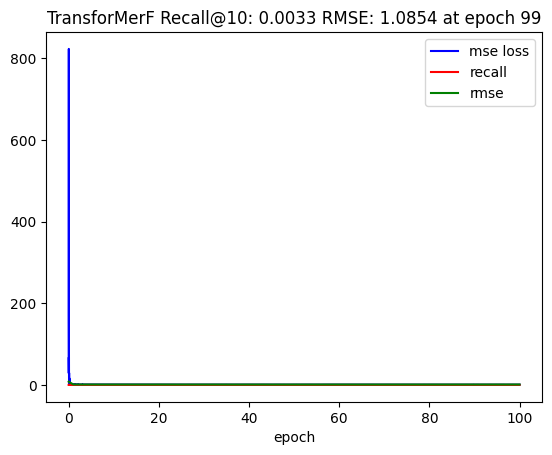

TransforMerF Recall@10: 0.0033 RMSE: 1.0854 at epoch 99


In [6]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 100
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'TransforMerF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'TransforMerF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

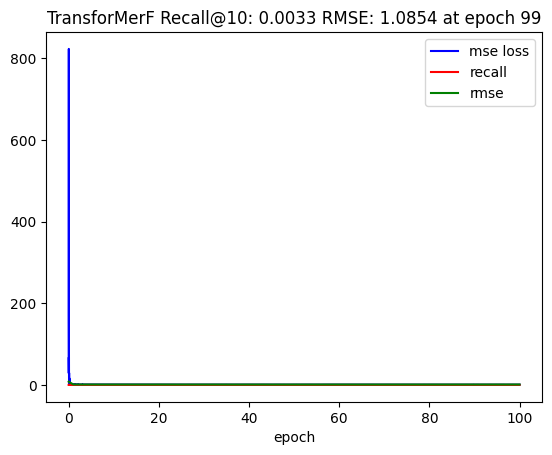

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'TransforMerF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.savefig(f'./images/TransforMerF Embed_dim: {n_factors} Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}.png')
plt.show()

In [8]:
recall_list

[0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.003278688524590164,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003278688524590164,
 0.001639344262295082,
 0.003278688524590164,
 0.001639344262295082,
 0.003278688524590164,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.003278688524590164,
 0.001639344262295082,
 0.004918032786885246,
 0.001639344262295082,
 0.0,
 0.0,
 0.003278688524590164,
 0.0,
 0.001639344262295082,
 0.003278688524590164,
 0.003278688524590164,
 0.001639344262295082,
 0.001639344262295082,
 0.00

In [9]:
rmse_list

[8.009626318969646,
 1.3334997142852947,
 1.1783728442566392,
 1.140536004343964,
 1.0982353339133197,
 1.0860609354904769,
 1.0754632572652871,
 1.0523964758948459,
 1.0427918016153144,
 1.0589522989748932,
 1.058412599724029,
 1.055456996939819,
 1.0596141331484343,
 1.0485602521597712,
 1.035960047319702,
 1.0367868500271507,
 1.0285345218485753,
 1.0384472050587825,
 1.0263814153873794,
 1.041027705997413,
 1.0714261463682795,
 1.0482966889879055,
 1.0335448768923166,
 1.0426085918229828,
 1.020749996961696,
 1.0329324695896063,
 1.0385881072399414,
 1.0271537808186626,
 1.031253930286663,
 1.027377225961396,
 1.0355698245170122,
 1.019809144246651,
 1.064418239196828,
 1.0306926145749957,
 1.0522603115882547,
 1.0338341673382778,
 1.0291749711930722,
 1.0338049940174974,
 1.021675865065553,
 1.032433033542612,
 1.045183894025215,
 1.0171229539775393,
 1.039898013011033,
 1.0611988964739374,
 1.0173138588328343,
 1.0228861131527067,
 1.0231219671597094,
 1.013346243062939,
 1.02672

In [10]:
# max(recall_list), min(rmse_list) 
print(f'TransforMerF Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'TransforMerF Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

TransforMerF Max Recall@10: 0.0066 at epoch 96
TransforMerF Min RMSE: 1.0034 at epoch 64
